## This notebook implements the FeINFN method on the University of Houston RGB and Hyperspectral images

Imports

In [1]:
import numpy as np
import scipy.io as sio
import time
import random
import cv2
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import math
import os
from spectral import *
from tqdm import trange
from argparse import Namespace
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import gamma, kv, erf

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
import torchsummary
import torchprofile

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

Helper Functions

In [3]:
# Defining the Gaussian PSF for synthetic data generation

kernel_size = 7
sigma = 3.40

def gaussian_psf(sigma, psf_size):
    """Generate a Gaussian PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf = psf / psf.sum()
    return psf
gaus_psf = gaussian_psf(sigma, kernel_size)

In [4]:
# Function to apply PSF to an image
def apply_psf(image, psf):
    
    """
    Convolve each channel of 'image' with 'psf' using 'same' padding.

    Parameters:
    -----------
    image : np.ndarray
        Shape (height, width, channels).
    psf   : np.ndarray
        Shape (kernel_height, kernel_width).
        
    Returns:
    --------
    blurred_image : np.ndarray
        Same shape as input image (height, width, channels).
    """
    
    # Prepare an output array of the same shape as 'image'
    blurred_image = np.zeros_like(image, dtype=np.float32)

    # Convolve each channel separately
    channels = image.shape[2]
    for c in range(channels):
        # convolve2d with mode='same' replicates TensorFlow's 'SAME' padding
        blurred_image[:, :, c] = convolve2d(image[:, :, c], psf, mode='same')
        
    return blurred_image
    
# Function to downsample an image
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image
    
# Function to add noise to an image
def add_awgn_noise(hsi_image, SNR_dB):
    
    """
    Add AWGN (Additive White Gaussian Noise) to the input hsi_image,
    given a desired SNR in dB. Uses NumPy only.

    Parameters
    ----------
    hsi_image : np.ndarray
        Input image of shape (rows, cols, channels).
    SNR_dB : float
        Desired SNR in decibels.

    Returns
    -------
    noisy_hsi_image : np.ndarray
        Noisy image of the same shape as hsi_image.
    """

     # Ensure float32
    hsi_image = hsi_image.astype(np.float32)

    rows, cols, channels = hsi_image.shape

    # Compute the signal power for each channel
    # shape: (channels,)
    signal_power = np.mean(hsi_image ** 2, axis=(0, 1))

    # Convert SNR from dB to linear scale
    SNR_linear = 10 ** (SNR_dB / 10.0)

    # Compute noise power and noise standard deviation per channel
    noise_power = signal_power / SNR_linear  # shape: (channels,)
    noise_std = np.sqrt(noise_power)         # shape: (channels,)

    # Reshape for broadcasting across (rows, cols)
    noise_std = noise_std.reshape((1, 1, channels))

    # Generate white Gaussian noise
    noise = np.random.normal(
        loc=0.0, 
        scale=1.0, 
        size=(rows, cols, channels)
    ).astype(np.float32)

    # Scale noise by the computed standard deviation
    noise *= noise_std

    # Add noise to the original image
    noisy_hsi_image = hsi_image + noise

    return noisy_hsi_image
    
# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

# Function to obtain the Spectral Response Function for spectral degradation
def get_srf_bands(num_bands: int) -> np.ndarray:
    """
    Return a (num_bands, 3) array of [center_nm, low_edge_nm, high_edge_nm]
    matching the specified 'num_bands' from {1,3,4,8,16}.
    
    1-band  => IKONOS Panchromatic
    3-bands => IKONOS RGB
    4-bands => IKONOS B, G, R, NIR
    8-bands => WorldView-2 
    16-bands => WorldView-3

    Raises ValueError if num_bands is not in [1,3,4,8,16].
    """

    if num_bands == 1:
        # IKONOS panchromatic
        band_specs = np.array([
            [729.0, 409.0, 1048.0]  # center, lower, upper
        ], dtype=np.float32)
    
    elif num_bands == 3:
        # IKONOS RGB
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)
    
    elif num_bands == 4:
        # IKONOS B, G, R, NIR
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
            [803.0, 713.0, 893.0],  # NIR
        ], dtype=np.float32)

    elif num_bands == 8:
        # WorldView-2
        band_specs = np.array([
            [427.0, 396.0, 458.0],  # Coastal Blue
            [478.0, 442.0, 515.0],  # Blue
            [546.0, 506.0, 586.0],  # Green
            [608.0, 584.0, 632.0],  # Yellow
            [659.0, 624.0, 694.0],  # Red
            [724.0, 699.0, 749.0],  # Red Edge
            [833.0, 765.0, 901.0],  # NIR1
            [949.0, 856.0, 1043.0], # NIR2
        ], dtype=np.float32)
    
    elif num_bands == 16:
        # WorldView-3
        band_specs = np.array([
            [426.0, 397.0, 454.0],    # Coastal Blue
            [481.0, 445.0, 517.0],    # Blue
            [547.0, 507.0, 586.0],    # Green
            [605.0, 580.0, 629.0],    # Yellow
            [661.0, 626.0, 696.0],    # Red
            [724.0, 698.0, 749.0],    # Red Edge
            [832.0, 765.0, 899.0],    # NIR1
            [948.0, 857.0, 1039.0],   # NIR2
            [1210.0, 1184.0, 1235.0], # SWIR1
            [1572.0, 1546.0, 1598.0], # SWIR2
            [1661.0, 1636.0, 1686.0], # SWIR3
            [1730.0, 1702.0, 1759.0], # SWIR4
            [2164.0, 2137.0, 2191.0], # SWIR5
            [2203.0, 2174.0, 2232.0], # SWIR6
            [2260.0, 2228.0, 2292.0], # SWIR7
            [2329.0, 2285.0, 2373.0], # SWIR8
        ], dtype=np.float32)
    
    else:
        raise ValueError(f"Unsupported num_bands={num_bands}. Must be 1,3,4,8, or 16.")

    return band_specs
    
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
        Examples: 
            - 1-band IKONOS Panchromatic 
            - 3-band IKONOS RGB 
            - 4-band IKONOS (B,G,R,NIR) 
            - 8-band WorldView-2 
            - 16-band WorldView-3
        etc.
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [5]:
# Function to visualize an HSI
def visualize_hsi(img1, img2, bands, title1, title2):
    """
    Visualize two hyperspectral images side by side using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    img2 : np.ndarray
        Second hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation (applied to both images).
    title1 : str
        Title for the first image.
    title2 : str
        Title for the second image.
    """
    rgb1 = get_rgb(img1, bands)
    rgb2 = get_rgb(img2, bands)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    axs[0].imshow(rgb1)
    axs[0].set_title(title1)
    axs[0].axis('on')

    axs[1].imshow(rgb2)
    axs[1].set_title(title2)
    axs[1].axis('on')

    plt.tight_layout()
    plt.show()

In [6]:
# Function to visualize an HSI
def visualize_hsi_single(img1, bands, title1):
    """
    Visualize a hyperspectral image using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation
    title1 : str
        Title for the first image.
    """
    rgb1 = get_rgb(img1, bands)

    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.imshow(rgb1)
    ax.set_title(title1)
    ax.axis('on')

    plt.tight_layout()
    plt.show()
    
# Function to visualize an MSI/RGB/Panchromatic image along with the SRF
def plot_multispectral_with_srf(ms_image, bands, title, srf, wavelengths, ikonos_bands):
    """
    Visualize a multispectral (or RGB/panchromatic) image alongside its Spectral Response Function (SRF).
    
    Parameters
    ----------
    ms_image : np.ndarray
        Multispectral image, shape: (rows, cols, num_bands).
    bands : tuple
        Band indices to use for RGB representation (only used if num_bands >= 3).
    title : str
        Title for the image plot.
    srf : np.ndarray
        Spectral Response Function, shape: (num_bands, L).
    wavelengths : np.ndarray
        Wavelengths corresponding to the L hyperspectral bands (x-axis for SRF).
    ikonos_bands : np.ndarray
        An array with shape (num_bands, 3) containing [center_nm, low_edge_nm, high_edge_nm]
        for each band. It is used here just to show the center wavelength in the legend.
    
    Notes
    -----
    - This function assumes num_bands is one of {1,3,4,8,16}.
    - If num_bands=1, we skip get_rgb and just display a grayscale single-band image.
    - If num_bands=3,4,8,16, we attempt to display an RGB image using 'bands' for the channel ordering.
    - The SRF curve colors and labels are chosen via if/elif blocks, 
      matching each possible number of bands.
    """
    num_bands = ms_image.shape[2]  # e.g. 1,3,4,8,16

    # 1) Choose band labels & colors depending on how many bands we have
    if num_bands == 1:
        band_labels = ["Panchromatic"]
        band_colors = ["k"]
    elif num_bands == 3:
        band_labels = ["Blue", "Green", "Red"]
        band_colors = ["b", "g", "r"]
    elif num_bands == 4:
        band_labels = ["Blue", "Green", "Red", "NIR"]
        band_colors = ["b", "g", "r", "k"]
    elif num_bands == 8:
        band_labels = ["Coastal", "Blue", "Green", "Yellow", 
                       "Red", "Red Edge", "NIR1", "NIR2"]
        # You can pick any 8 distinct colors you like:
        band_colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]
    elif num_bands == 16:
        band_labels = [
            "Coastal Blue", "Blue", "Green", "Yellow", 
            "Red", "Red Edge", "NIR1", "NIR2",
            "SWIR1", "SWIR2", "SWIR3", "SWIR4",
            "SWIR5", "SWIR6", "SWIR7", "SWIR8"
        ]
        # Again, pick any 16 distinct colors you like:
        band_colors = [
            "b", "g", "r", "c", "m", "y", "k", "orange", 
            "purple", "brown", "pink", "gray", 
            "olive", "navy", "teal", "maroon"
        ]
    else:
        raise ValueError("Function only supports images with 1, 3, 4, 8, or 16 bands.")
    
    # 2) Create the figure with 2 subplots (image on the left, SRF on the right)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # 3) Plot the image
    if num_bands == 1:
        # Just display the single-band image in grayscale
        single_band_2d = ms_image[:, :, 0]  # shape (rows, cols)
        axs[0].imshow(single_band_2d, cmap="gray")
        axs[0].set_title(title + " (Single-Band/Panchromatic)")
    else:
        # We have at least 3 bands, so let's form an RGB image
        img_rgb = get_rgb(ms_image, bands)
        axs[0].imshow(img_rgb)
        axs[0].set_title(title)
    axs[0].axis('off')
    
    # 4) Plot the SRF curves in the second subplot
    for i in range(num_bands):
        center_nm = ikonos_bands[i, 0]  # The 'center' column from your band_specs
        axs[1].plot(
            wavelengths,
            srf[i, :],
            label=f'{band_labels[i]} (Center: {center_nm} nm)',
            color=band_colors[i]
        )
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Spectral Response')
    axs[1].set_title('Spectral Response Functions (SRF)')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

Importing the University of Houston images

In [7]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Real_world_Fusion_based_HSI_Super_Resolution_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
hsi_1_file_path = os.path.join(normalized_dataset_path, 'hsi_1.mat')
hsi_2_file_path = os.path.join(normalized_dataset_path, 'hsi_2.mat')
rgb_1_file_path = os.path.join(normalized_dataset_path, 'rgb_image_1.tif')
rgb_2_file_path = os.path.join(normalized_dataset_path, 'rgb_image_2.tif')

In [8]:
def extract_aligned_patches(lr_hsi, hr_rgb, hsi_center_y, hsi_center_x,
                            hsi_patch_size=64, rgb_scale_factor=20, rgb_downsampled_size=512):
    """
    Extract a 64x64 patch from the LR HSI centered at (hsi_center_y, hsi_center_x),
    and the corresponding 1280x1280 patch from the HR RGB image centered at the
    scaled coordinates. Then downsample the RGB patch to 512x512.

    Parameters:
    -----------
    lr_hsi : np.ndarray
        Low-resolution HSI image of shape (H_lr, W_lr, C_hsi).
    hr_rgb : np.ndarray
        High-resolution RGB image of shape (H_hr, W_hr, 3).
    hsi_center_y : int
        Y-coordinate of the HSI patch center.
    hsi_center_x : int
        X-coordinate of the HSI patch center.
    hsi_patch_size : int
        Patch size for the HSI (default: 64).
    rgb_scale_factor : int
        Scaling factor between HSI and RGB resolutions (default: 20).
    rgb_downsampled_size : int
        Final size of the RGB patch after downsampling (default: 512).

    Returns:
    --------
    hsi_patch : np.ndarray
        Extracted HSI patch of shape (hsi_patch_size, hsi_patch_size, C_hsi).
    rgb_patch_downsampled : np.ndarray
        Downsampled RGB patch of shape (rgb_downsampled_size, rgb_downsampled_size, 3).
    """
    
    # --- HSI patch extraction ---
    half_hsi = hsi_patch_size // 2
    hsi_top = hsi_center_y - half_hsi
    hsi_left = hsi_center_x - half_hsi

    if (hsi_top < 0 or hsi_left < 0 or 
        hsi_top + hsi_patch_size > lr_hsi.shape[0] or 
        hsi_left + hsi_patch_size > lr_hsi.shape[1]):
        raise ValueError("HSI patch goes out of bounds.")

    hsi_patch = lr_hsi[
        hsi_top : hsi_top + hsi_patch_size,
        hsi_left : hsi_left + hsi_patch_size,
        :
    ]

    # --- RGB patch extraction ---
    rgb_patch_size = hsi_patch_size * rgb_scale_factor
    half_rgb = rgb_patch_size // 2
    rgb_center_y = hsi_center_y * rgb_scale_factor
    rgb_center_x = hsi_center_x * rgb_scale_factor
    rgb_top = rgb_center_y - half_rgb
    rgb_left = rgb_center_x - half_rgb

    if (rgb_top < 0 or rgb_left < 0 or 
        rgb_top + rgb_patch_size > hr_rgb.shape[0] or 
        rgb_left + rgb_patch_size > hr_rgb.shape[1]):
        raise ValueError("RGB patch goes out of bounds.")

    rgb_patch = hr_rgb[
        rgb_top : rgb_top + rgb_patch_size,
        rgb_left : rgb_left + rgb_patch_size,
        :
    ]

    # --- Downsample the RGB patch ---
    rgb_patch_downsampled = cv2.resize(
        rgb_patch,
        (rgb_downsampled_size, rgb_downsampled_size),
        interpolation=cv2.INTER_AREA
    )

    return hsi_patch, rgb_patch_downsampled

In [9]:
hsi_1 = sio.loadmat(hsi_1_file_path)
hsi_1_image = hsi_1['topLeft']

# Load image
RGB_1 = cv2.imread(rgb_1_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_1_image = np.array(RGB_1)

hsi_patch_1, rgb_patch_1 = extract_aligned_patches(
    lr_hsi=hsi_1_image,
    hr_rgb=RGB_1_image,
    hsi_center_y=400,
    hsi_center_x=450
)

hsi_1_test = normalize(hsi_patch_1)
RGB_1_test = normalize(rgb_patch_1)

In [10]:
hsi_2 = sio.loadmat(hsi_2_file_path)
hsi_2_image = hsi_2['bottomRight']

# Load image
RGB_2 = cv2.imread(rgb_2_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_2_image = np.array(RGB_2)

hsi_patch_2, rgb_patch_2 = extract_aligned_patches(
    lr_hsi=hsi_2_image,
    hr_rgb=RGB_2_image,
    hsi_center_y=400,
    hsi_center_x=400
)

hsi_2_test = normalize(hsi_patch_2)
RGB_2_test = normalize(rgb_patch_2)

Establishing training and inference images for the super resolution method

In [11]:
# Function to spatially degrade an image
def spatial_degradation(image, psf, downsample_ratio, SNR):
    """
    Apply spatial degradation to an image.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image.
    psf : np.ndarray
        Point Spread Function.
    downsample_ratio : int
        Factor by which to downsample.
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    
    Returns:
    --------
    degraded_image : np.ndarray
        Spatially degraded image.
    """
    I_HS = normalize(image)
    I_HS = apply_psf(I_HS, psf)
    I_HS = downsample_image(I_HS, downsample_ratio)
    I_HS = add_awgn_noise(I_HS, SNR)
    return I_HS

# Function to spectrally degrade an image
def spectral_degradation(image, SNR, num_bands=4, fwhm_factor=4.3):
    """
    Apply spectral degradation to an image.
    
    Parameters
    ----------
    image : np.ndarray
        Input HSI image, shape (rows, cols, L).
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    num_bands : int
        Desired number of output bands. Must be one of {1,3,4,8,16}.
        1 => IKONOS Panchromatic
        3 => IKONOS RGB
        4 => IKONOS B/G/R/NIR
        8 => WorldView-2
        16 => WorldView-3
    fwhm_factor : float
        Factor to approximate std dev from (upper_edge - lower_edge).
        Default=4.2 is typical for a rough Gaussian FWHM approximation.

    Returns
    -------
    I_MS : np.ndarray
        Spectrally degraded image of shape (rows, cols, num_bands).
    srf : np.ndarray
        The sensor SRF curves, shape (num_bands, L).
    band_specs : np.ndarray
        The band specs used, shape (num_bands, 3).
    auto_wavelengths : np.ndarray
        The automatically generated wavelengths, shape (L,).
    """
    
    # 1) Fetch the band specs for the desired sensor configuration
    band_specs = get_srf_bands(num_bands)

    # 2) Normalize the image to [0,1] (or however your normalize function works)
    I_MS = normalize(image)

    # 3) Apply the SRF to produce the 'multispectral' (or panchromatic/RGB) image
    I_MS, srf, auto_wavelengths = apply_srf(I_MS, band_specs, fwhm_factor=fwhm_factor)

    # 4) Add AWGN noise
    I_MS = add_awgn_noise(I_MS, SNR)

    # 5) Return the result plus info you might need for plotting or further usage
    return I_MS, srf, band_specs, auto_wavelengths

In [12]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Synthetic_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
mat_file_path = os.path.join(normalized_dataset_path, 'Pavia_center_data.mat')

In [13]:
def plot_alignment_grid_np(lr_hsi, hr_msi, hr_hsi, up_lr_hsi,
                           band_lr=25, band_hr=25, num_samples=3):
    """
    Visualize random patches from NumPy arrays including:
    - LR HSI
    - HR MSI
    - GT HR HSI
    - Upsampled LR HSI
    
    Args:
        lr_hsi     : (N, 50, 64, 64)   - low-res HSI
        hr_msi     : (N, 3, 512, 512)  - RGB (MSI)
        hr_hsi     : (N, 50, 512, 512) - GT HR HSI
        up_lr_hsi  : (N, 50, 512, 512) - upsampled LR HSI to HR resolution
    """
    indices = np.random.choice(len(lr_hsi), size=num_samples, replace=False)
    fig, axs = plt.subplots(num_samples, 4, figsize=(13, 3 * num_samples))

    for i, idx in enumerate(indices):
        lr   = np.transpose(lr_hsi[idx], (1, 2, 0))       # (64, 64, 50)
        msi  = np.transpose(hr_msi[idx], (1, 2, 0))       # (512, 512, 3)
        hr   = np.transpose(hr_hsi[idx], (1, 2, 0))       # (512, 512, 50)
        up   = np.transpose(up_lr_hsi[idx], (1, 2, 0))    # (512, 512, 50)

        axs[i, 0].imshow(lr[:, :, band_lr], cmap='gray')
        axs[i, 0].set_title(f"LR HSI (band {band_lr})")

        axs[i, 1].imshow(msi / msi.max())
        axs[i, 1].set_title("HR MSI (RGB)")

        axs[i, 2].imshow(hr[:, :, band_hr], cmap='gray')
        axs[i, 2].set_title(f"GT HR HSI (band {band_hr})")

        axs[i, 3].imshow(up[:, :, band_hr], cmap='gray')
        axs[i, 3].set_title(f"Upsampled LR HSI (band {band_hr})")

        for j in range(4):
            axs[i, j].axis('off')

    plt.tight_layout()
    fig.suptitle("Patch Alignment: LR HSI, HR MSI, GT HR HSI, Upsampled LR HSI", fontsize=16)
    plt.subplots_adjust(top=0.93)
    plt.show()

Ground truth image shape:  (1096, 712, 50)


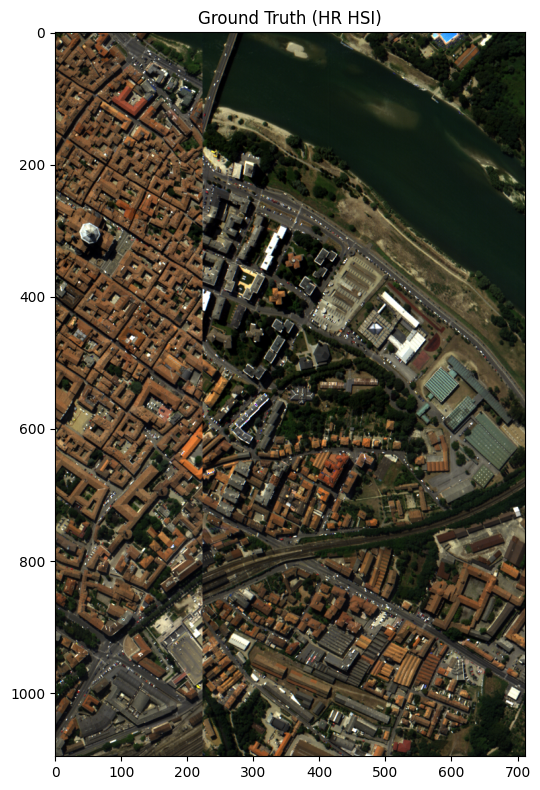

MSI shape:  (1096, 712, 3)


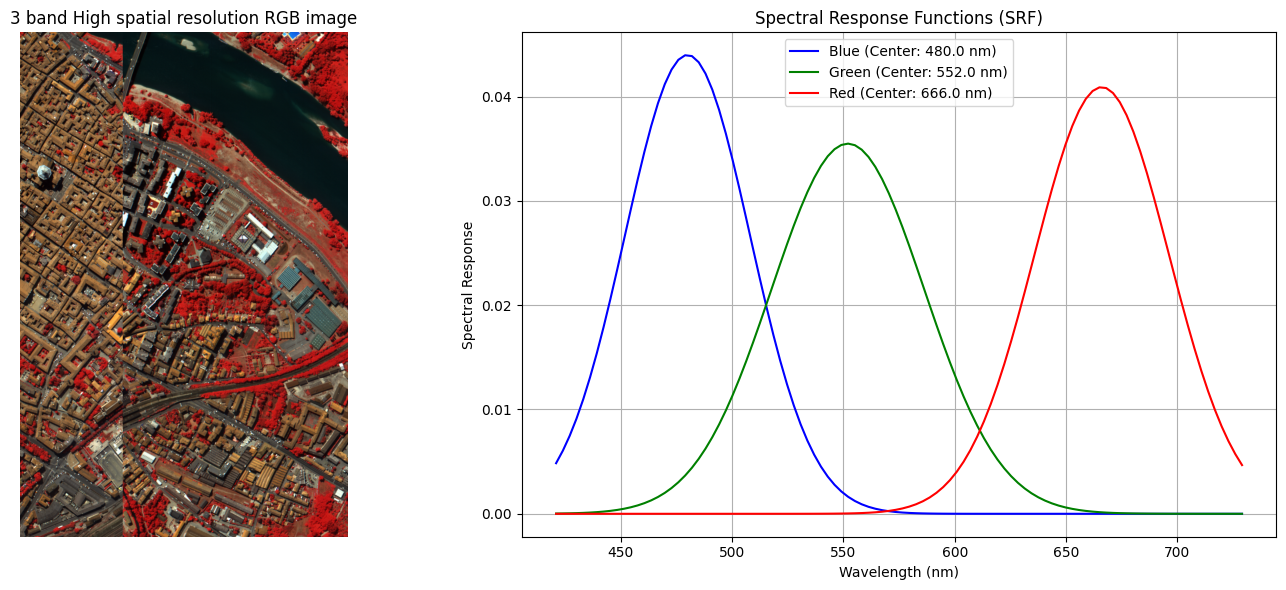

HSI shape with 8x Downsample:  (137, 89, 50)


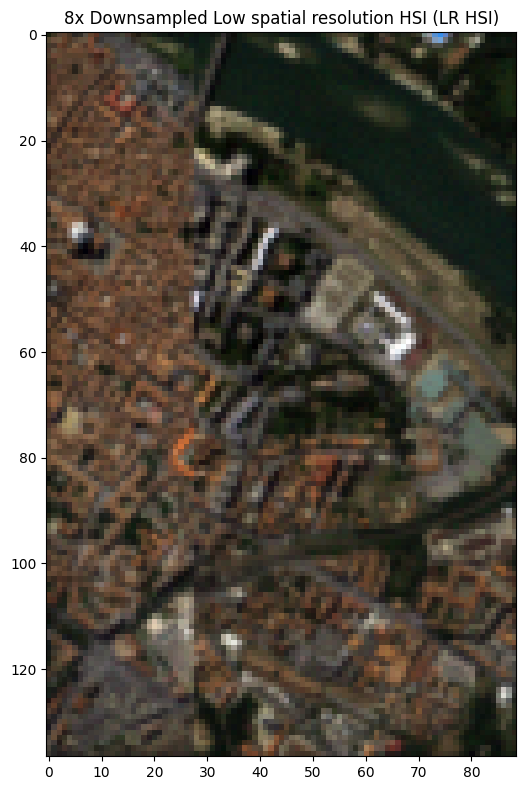

In [14]:
pavia_center = sio.loadmat(mat_file_path)
pavia_center_image = pavia_center['pavia']
pavia_center_image = pavia_center_image[:, :712, :]

# Select 50 uniformly spaced bands
selected_band_idxs = np.linspace(0, 101, 50, dtype=int)

# Ground Truth HR HSI (H, W, C)
I_REF = normalize(pavia_center_image)
# Downsampling spectrally from 102 to 50 bands to make the training as close as possible to inference
I_REF = I_REF[:, :, selected_band_idxs]
print("Ground truth image shape: ", I_REF.shape)
visualize_hsi_single(I_REF, (25,17,7), "Ground Truth (HR HSI)")

# High Resolution MSI with 3 bands
I_MS_3, srf_3, band_specs_3, auto_wavs_3 = spectral_degradation(image=pavia_center_image, SNR=40, num_bands=3, fwhm_factor=4.2)
print("MSI shape: ", I_MS_3.shape)
plot_multispectral_with_srf(I_MS_3, (2,1,0), "3 band High spatial resolution RGB image", srf_3, auto_wavs_3, band_specs_3)

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gaus = spatial_degradation(pavia_center_image, gaus_psf, 8, 30)
# Downsampling spectrally from 102 to 50 bands to make the training as close as possible to inference
I_HS_8_gaus = I_HS_8_gaus[:, :, selected_band_idxs]
print("HSI shape with 8x Downsample: ", I_HS_8_gaus.shape)
visualize_hsi_single(I_HS_8_gaus, (25,17,7), "8x Downsampled Low spatial resolution HSI (LR HSI)")

UH Hyperspectral image 1 inference shape:  (64, 64, 50)
UH Hyperspectral image 2 inference shape:  (64, 64, 50)


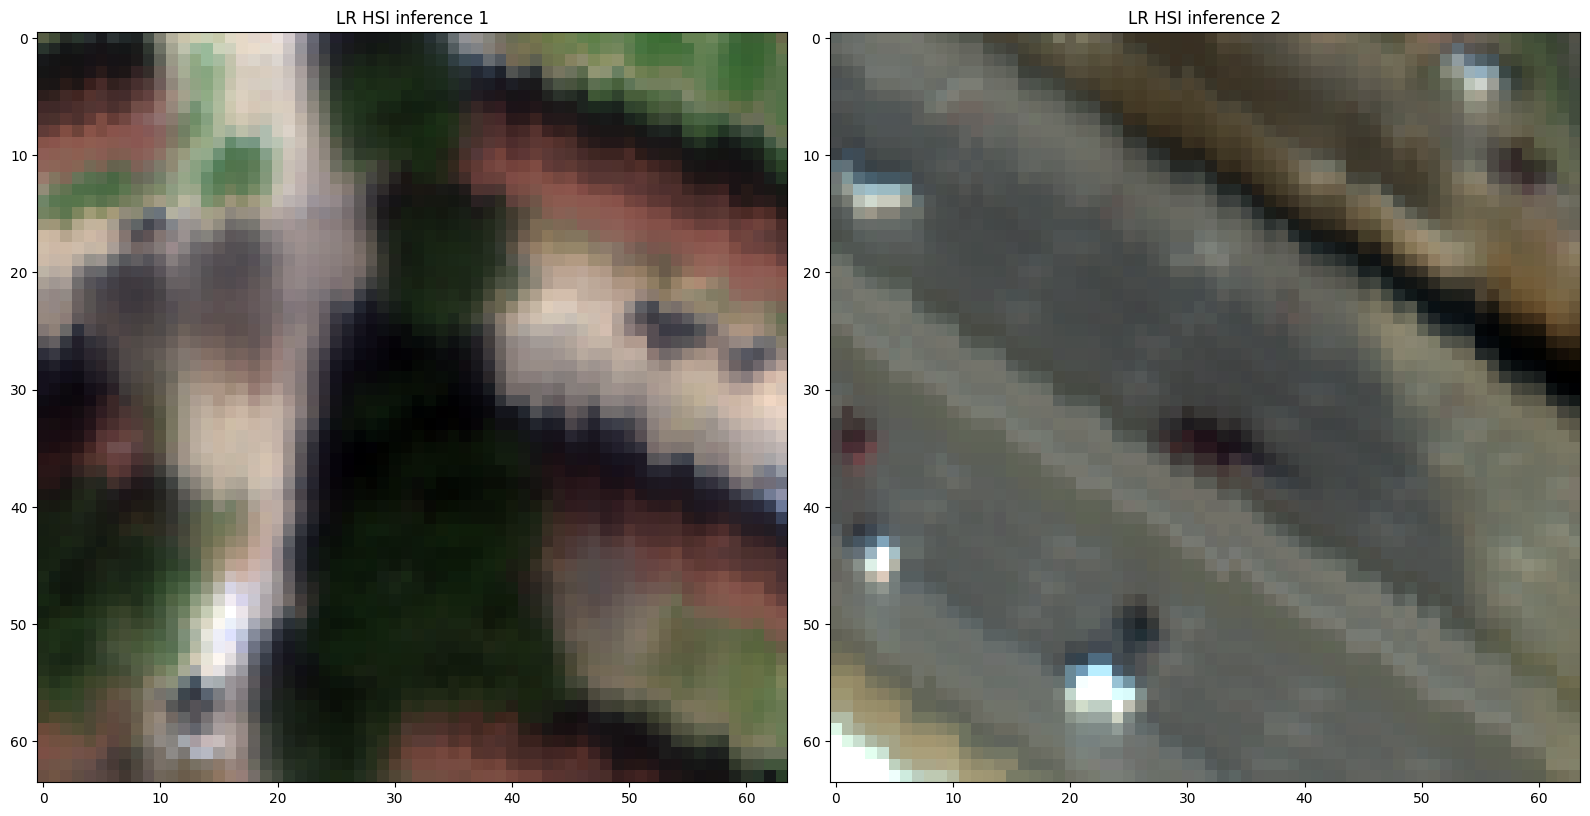

In [15]:
LR_HSI_test_1 = hsi_1_test
print("UH Hyperspectral image 1 inference shape: ", LR_HSI_test_1.shape)

LR_HSI_test_2 = hsi_2_test
print("UH Hyperspectral image 2 inference shape: ", LR_HSI_test_2.shape)

visualize_hsi(LR_HSI_test_1, LR_HSI_test_2, (20,13,8), "LR HSI inference 1", "LR HSI inference 2")

UH RGB image 1 inference shape:  (512, 512, 3)
UH RGB image 2 inference shape:  (512, 512, 3)


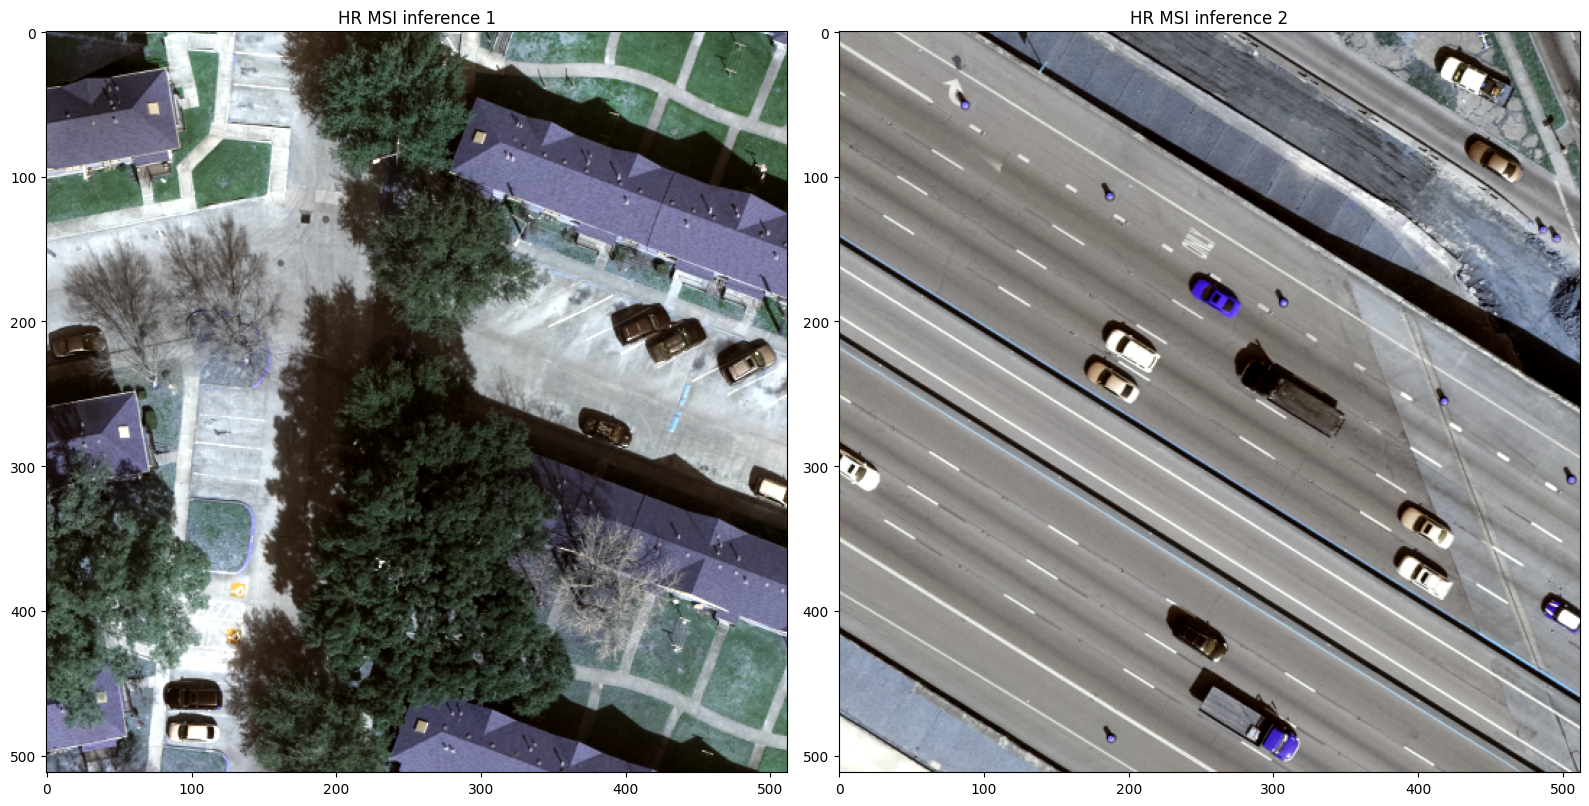

In [16]:
HR_MSI_test_1 = RGB_1_test
print("UH RGB image 1 inference shape: ", HR_MSI_test_1.shape)

HR_MSI_test_2 = RGB_2_test
print("UH RGB image 2 inference shape: ", HR_MSI_test_2.shape)

visualize_hsi(HR_MSI_test_1, HR_MSI_test_2, (0,1,2), "HR MSI inference 1", "HR MSI inference 2")

Fourier-enhanced Implicit Neural Fusion Network for Multispectral and Hyperspectral Image Fusion implementation from their GitHub

In [17]:
def get_flops_fvcore(model, inputs):
    """
    Estimate FLOPs and parameter count using fvcore.

    Parameters
    ----------
    model : torch.nn.Module
        Your model.
    inputs : tuple
        Tuple of input tensors (e.g., (pan, lms, ms)).

    Returns
    -------
    flops : str
        FLOPs in readable format.
    param_table : str
        Parameter count in table format.
    """
    model.eval()
    with torch.no_grad():
        flops = FlopCountAnalysis(model, inputs)
        flops_total = flops.total()
        params = parameter_count_table(model, max_depth=2)
    return flops_total, params

In [18]:
def make_patches(hr_hsi, hr_msi, lr_hsi, upsampled_lr_hsi,
                 patch_hr=32, scale=8, stride_hr=256):
    """
    hr_hsi           : (H, W, C_hsi)       - Ground truth
    hr_msi           : (H, W, C_msi)       - High-res MSI (e.g., RGB)
    lr_hsi           : (H/scale, W/scale, C_hsi) - Low-res HSI
    upsampled_lr_hsi : (H, W, C_hsi)       - LR HSI upsampled to HR spatial size

    Returns four numpy arrays in (N, C, H, W) format:
        HR_MSI, LR_HSI, HR_HSI, Upsampled_LR_HSI
    """
    stride_lr = stride_hr // scale

    def extract(img, p, s):
        H, W, C = img.shape
        out = []
        for y in range(0, H - p + 1, s):
            for x in range(0, W - p + 1, s):
                out.append(img[y:y + p, x:x + p, :])
        return np.stack(out)

    HR_HSI      = extract(hr_hsi, patch_hr, stride_hr).transpose(0, 3, 1, 2)
    HR_MSI      = extract(hr_msi, patch_hr, stride_hr).transpose(0, 3, 1, 2)
    LR_HSI      = extract(lr_hsi, patch_hr // scale, stride_lr).transpose(0, 3, 1, 2)
    UP_LR_HSI   = extract(upsampled_lr_hsi, patch_hr, stride_hr).transpose(0, 3, 1, 2)

    return HR_MSI.astype(np.float32), LR_HSI.astype(np.float32), HR_HSI.astype(np.float32), UP_LR_HSI.astype(np.float32)

class PatchDS(torch.utils.data.Dataset):
    def __init__(self, msi, lr, gt, up_lr):
        self.msi, self.lr, self.gt, self.up_lr = map(torch.tensor, (msi, lr, gt, up_lr))

    def __len__(self):
        return self.msi.size(0)

    def __getitem__(self, i):
        return self.msi[i], self.lr[i], self.gt[i], self.up_lr[i]

In [19]:
# base_model.py

MODELS = {}

# use it in a decorator way
# e.g.
# @register_model('model_name')
def register_model(name):
    def inner(cls):
        MODELS[name] = cls
        return cls

    return inner


# base model class
# all model defination should inherit this class
from abc import ABC, abstractmethod
class BaseModel(ABC, nn.Module):
    
    @classmethod
    def __init_subclass__(cls, **kwargs):
        super().__init_subclass__(**kwargs)
        if not (cls._is_method_implemented('train_step') or cls._is_method_implemented('fusion_train_step')):
            raise NotImplementedError(f"{cls.__name__} must implement at least one of the methods: 'train_step' or 'fusion_train_step'")

        if not (cls._is_method_implemented('val_step') or cls._is_method_implemented('fusion_val_step')):
            raise NotImplementedError(f"{cls.__name__} must implement at least one of the methods: 'val_step' or 'fusion_val_step'")

    @staticmethod
    def _is_method_implemented(method):
        return any(method in B.__dict__ for B in BaseModel.__subclasses__())
    
    def train_step(
        self, ms, lms, pan, gt, criterion
    ) -> tuple[torch.Tensor, tuple[Tensor, dict[str, Tensor]]]:
        raise NotImplementedError

    def val_step(self, ms, lms, pan) -> torch.Tensor:
        raise NotImplementedError
    
    def fusion_train_step(self, vis, ir, mask, gt, criterion) -> tuple[torch.Tensor, tuple[Tensor, dict[str, Tensor]]]:
        raise NotImplementedError
    
    def fusion_val_step(self, vis, ir, mask) -> torch.Tensor:
        raise NotImplementedError

    def patch_merge_step(self, *args) -> torch.Tensor:
        # not compulsory
        raise NotImplementedError

    def forward(self, *args, mode="train", **kwargs):
        if mode == "train":
            return self.train_step(*args, **kwargs)
        elif mode == "eval":
            return self.val_step(*args, **kwargs)
        elif mode == 'fusion_train':
            return self.fusion_train_step(*args, **kwargs)
        elif mode == 'fusion_eval':
            return self.fusion_val_step(*args, **kwargs)
        elif mode == "patch_merge":
            raise DeprecationWarning("patch_merge is deprecated.")
            # return self.patch_merge_step(*args, **kwargs)
        else:
            raise NotImplementedError

    @abstractmethod
    def _forward_implem(self, *args, **kwargs):
        raise NotImplementedError

In [20]:
# fe_block.py

def make_coord(shape, ranges=None, flatten=True):
    """ Make coordinates at grid centers.
    """
    coord_seqs = []
    for i, n in enumerate(shape):
        if ranges is None:
            v0, v1 = -1, 1
        else:
            v0, v1 = ranges[i]
        r = (v1 - v0) / (2 * n)
        seq = v0 + r + (2 * r) * torch.arange(n).float()
        coord_seqs.append(seq)
    ret = torch.stack(torch.meshgrid(*coord_seqs), dim=-1)
    if flatten:
        ret = ret.view(-1, ret.shape[-1])
    return ret

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class MeanShift(nn.Conv2d):
    def __init__(
        self, rgb_range,
        rgb_mean=(0.4488, 0.4371, 0.4040), rgb_std=(1.0, 1.0, 1.0), sign=-1):

        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1) / std.view(3, 1, 1, 1)
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean) / std
        for p in self.parameters():
            p.requires_grad = False
            
class ResBlock(nn.Module):
    def __init__(
        self, conv, n_feats, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feats, n_feats, kernel_size, bias=bias))
            if bn:
                m.append(nn.BatchNorm2d(n_feats))
            if i == 0:
                m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class EDSR(nn.Module):
    def __init__(self, args, conv=default_conv):
        super(EDSR, self).__init__()
        self.args = args
        n_resblocks = args.n_resblocks
        n_feats = args.n_feats
        kernel_size = 3
        scale = args.scale[0]
        act = nn.ReLU(True)
        self.sub_mean = MeanShift(args.rgb_range)
        self.add_mean = MeanShift(args.rgb_range, sign=1)

        # define head module
        m_head = [conv(args.n_colors, n_feats, kernel_size)]

        # define body module
        m_body = [
            ResBlock(
                conv, n_feats, kernel_size, act=act, res_scale=args.res_scale
            ) for _ in range(n_resblocks)
        ]
        m_body.append(conv(n_feats, n_feats, kernel_size))

        self.head = nn.Sequential(*m_head)
        self.body = nn.Sequential(*m_body)

        if args.no_upsampling:
            self.out_dim = n_feats
        else:
            self.out_dim = args.n_colors
            # define tail module
            m_tail = [
                Upsampler(conv, scale, n_feats, act=False),
                conv(n_feats, args.n_colors, kernel_size)
            ]
            self.tail = nn.Sequential(*m_tail)

    def forward(self, x):
        #x = self.sub_mean(x)
        x = self.head(x)

        res = self.body(x)
        res += x

        if self.args.no_upsampling:
            x = res
        else:
            x = self.tail(res)
        #x = self.add_mean(x)
        return x

    def load_state_dict(self, state_dict, strict=True):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name in own_state:
                if isinstance(param, nn.Parameter):
                    param = param.data
                try:
                    own_state[name].copy_(param)
                except Exception:
                    if name.find('tail') == -1:
                        raise RuntimeError('While copying the parameter named {}, '
                                           'whose dimensions in the model are {} and '
                                           'whose dimensions in the checkpoint are {}.'
                                           .format(name, own_state[name].size(), param.size()))
            elif strict:
                if name.find('tail') == -1:
                    raise KeyError('unexpected key "{}" in state_dict'
                                   .format(name))


def make_edsr_baseline(n_resblocks=16, n_feats=64, res_scale=1, n_colors=1,
                       scale=2, no_upsampling=True, rgb_range=1):
    args = Namespace()
    args.n_resblocks = n_resblocks
    args.n_feats = n_feats
    args.res_scale = res_scale

    args.scale = [scale]
    args.no_upsampling = no_upsampling

    args.rgb_range = rgb_range
    args.n_colors = n_colors
    return EDSR(args)


def make_edsr(n_resblocks=32, n_feats=256, res_scale=0.1, n_colors=1,
              scale=2, no_upsampling=True, rgb_range=1):
    args = Namespace()
    args.n_resblocks = n_resblocks
    args.n_feats = n_feats
    args.res_scale = res_scale

    args.scale = [scale]
    args.no_upsampling = no_upsampling

    args.rgb_range = rgb_range
    args.n_colors = n_colors
    return EDSR(args)

class ComplexGaborLayer(nn.Module):
    '''
        Complex Gabor nonlinearity 

        Inputs:
            input: Input features
            omega0: Frequency of Gabor sinusoid term
            sigma0: Scaling of Gabor Gaussian term
            trainable: If True, omega and sigma are trainable parameters
    '''

    def __init__(self, omega0=30.0, sigma0=10.0, trainable=True):
        super().__init__()
        self.omega_0 = omega0
        self.scale_0 = sigma0

        # Set trainable parameters if they are to be simultaneously optimized
        self.omega_0 = nn.Parameter(self.omega_0 * torch.ones(1), trainable)
        self.scale_0 = nn.Parameter(self.scale_0 * torch.ones(1), trainable)

    def forward(self, input):
        input = input.permute(0, -2, -1, 1)

        omega = self.omega_0 * input
        scale = self.scale_0 * input
        # return torch.exp(1j * omega - scale.abs().square())
        return torch.exp(1j * omega - scale.abs().square()).permute(0, -1, 1, 2)
    
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=4096):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        pe = self.pe[None]
        if x.size(1) > self.pe.size(1):
            # pe shape: [1, max_len, d_model]
            pe = pe.transpose(1, 2)  # [1, d_model, max_len]
            pe = F.interpolate(pe, size=(x.size(1)), mode='linear')
            pe = pe.transpose(1, 2)  # [1, max_len, d_model]

        pe_x = pe[:, :x.size(1)]
        x = x + pe_x
        return x
    
class MLP_P(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_list):
        super().__init__()
        layers = []
        lastv = in_dim
        for hidden in hidden_list:
            layers.append(nn.Sequential(
                        nn.Conv2d(lastv, hidden, kernel_size=1, bias=False),
                        nn.Conv2d(hidden, hidden, kernel_size=3, padding=1, bias=False, groups=hidden),
                        ))
            layers.append(nn.ReLU())
            lastv = hidden
        layers.append(nn.Sequential(
                        nn.Conv2d(lastv, out_dim, kernel_size=1, bias=False),
                        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1, bias=False, groups=out_dim),
                        ))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_list):
        super().__init__()
        layers = []
        lastv = in_dim
        for hidden in hidden_list:
            layers.append(nn.Linear(lastv, hidden))
            layers.append(nn.ReLU())
            lastv = hidden
        layers.append(nn.Linear(lastv, out_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x
    
class hightfre(nn.Module):

    def __init__(self, in_channels=128, out_channels=128, groups=1):
        super().__init__()
        self.groups = groups
        self.inch = in_channels
        self.outch = out_channels

        kernel = torch.tensor([[0, -1, 0],
                               [-1, 1, -1],
                               [0, -1, 0]], dtype=torch.float32)
        self.register_buffer('kernel', kernel)

    def forward(self, x):
        output = F.conv2d(x, self.kernel[None, None].repeat_interleave(self.inch, dim=0), groups=self.inch, padding=1)
        return output  
    
class ImplicitDecoder(nn.Module):
    def __init__(self, in_channels, freq_dim=31, hidden_dims=[128,128,128], omega=30, scale=10.0):
        super().__init__()

        last_dim_K = in_channels 
        last_dim_Q = freq_dim

        self.K = nn.ModuleList()
        self.Q = nn.ModuleList()
        
        for hidden_dim in hidden_dims:
            self.K.append(nn.Sequential(nn.Conv2d(last_dim_K, hidden_dim, 1),
                                        nn.ReLU()))
            self.Q.append(nn.Sequential(nn.Conv2d(last_dim_Q, hidden_dim, 1),
                                        ComplexGaborLayer(omega0=omega,
                                                        sigma0=scale,
                                                        trainable=True)))
            last_dim_K = hidden_dim + in_channels
            last_dim_Q = hidden_dim

        self.last_layer = nn.Conv2d(hidden_dims[-1], in_channels-1, 1)

    def step(self, x, y):
        k = self.K[0](x).real
        q = k * self.Q[0](y)
        q = q.real
        for i in range(1, len(self.K)):
            k = self.K[i](torch.cat([q, x], dim=1)).real
            q = k * self.Q[i](q)
            q = q.real
        q = self.last_layer(q)
        return q

    def forward(self, INR_feat, freq_feat):
        output = self.step(INR_feat, freq_feat)
        return output

In [21]:
# FeINFN.py

class FourierUnit(nn.Module):

    def __init__(self, feat_dim=128, guide_dim=128, mlp_dim=[256, 128], NIR_dim=33, d_model=2):
        super().__init__()
        self.feat_dim = feat_dim
        self.guide_dim = guide_dim
        self.mlp_dim = mlp_dim

        imnet_in_dim = self.feat_dim + self.guide_dim + 2
        self.imnet1 = MLP(imnet_in_dim, out_dim=NIR_dim, hidden_list=self.mlp_dim)
        self.imnet2 = MLP_P(imnet_in_dim, out_dim=NIR_dim, hidden_list=self.mlp_dim)

        # self.pe = PositionalEmbedding(d_model, max_len=4096)

    def query_freq_a(self, feat, coord, hr_guide, mlp):
        # feat: [B, C, h, w]
        # coord: [B, N, 2], N <= H * W

        b, c, h, w = feat.shape  # lr  7x128x8x8
        _, _, H, W = hr_guide.shape  # hr  7x128x64x64
        coord = coord.expand(b, H * W, 2)
        B, N, _ = coord.shape

        # LR centers' coords
        feat_coord = make_coord((h, w), flatten=False).to(feat.device).permute(2, 0, 1).unsqueeze(0).expand(b, 2, h, w)

        q_guide_hr = F.grid_sample(hr_guide, coord.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                     :].permute(0, 2, 1)  # [B, N, C]

        rx = 1 / h
        ry = 1 / w

        preds = []

        for vx in [-1, 1]:
            for vy in [-1, 1]:
                coord_ = coord.clone()
                coord_[:, :, 0] += (vx) * rx
                coord_[:, :, 1] += (vy) * ry

                # feat: [B, c, h, w], coord_: [B, N, 2] --> [B, 1, N, 2], out: [B, c, 1, N] --> [B, c, N] --> [B, N, c]
                q_feat = F.grid_sample(feat, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                         :].permute(0, 2, 1)  # [B, N, c]
                q_coord = F.grid_sample(feat_coord, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[
                          :, :, 0, :].permute(0, 2, 1)  # [B, N, 2]

                rel_coord = coord - q_coord # b x (64x64) x 2
                rel_coord[:, :, 0] *= h
                rel_coord[:, :, 1] *= w

                inp = torch.cat([q_feat, q_guide_hr, rel_coord], dim=-1)

                pred = mlp(inp.view(B * N, -1)).view(B, N, -1)  # [B, N, 2]
                preds.append(pred)

        preds = torch.stack(preds, dim=-1)  # [B, N, 2, kk]
        weight = F.softmax(preds[:, :, -1, :], dim=-1)
        ret = (preds[:, :, 0:-1, :] * weight.unsqueeze(-2)).sum(-1, keepdim=True).squeeze(-1)
        ret = ret.permute(0, 2, 1).view(b, -1, H, W)

        return ret
    def query_freq_p(self, feat, coord, hr_guide, mlp):
        # feat: [B, C, h, w]
        # coord: [B, N, 2], N <= H * W

        b, c, h, w = feat.shape  # lr  7x128x8x8
        _, _, H, W = hr_guide.shape  # hr  7x128x64x64
        coord = coord.expand(b, H * W, 2)
        B, N, _ = coord.shape

        # LR centers' coords
        feat_coord = make_coord((h, w), flatten=False).to(feat.device).permute(2, 0, 1).unsqueeze(0).expand(b, 2, h, w)

        q_guide_hr = F.grid_sample(hr_guide, coord.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                     :].permute(0, 2, 1)  # [B, N, C]

        rx = 1 / h
        ry = 1 / w

        preds = []

        for vx in [-1, 1]:
            for vy in [-1, 1]:
                coord_ = coord.clone()
                coord_[:, :, 0] += (vx) * rx
                coord_[:, :, 1] += (vy) * ry

                # feat: [B, c, h, w], coord_: [B, N, 2] --> [B, 1, N, 2], out: [B, c, 1, N] --> [B, c, N] --> [B, N, c]
                q_feat = F.grid_sample(feat, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                         :].permute(0, 2, 1)  # [B, N, c]
                q_coord = F.grid_sample(feat_coord, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[
                          :, :, 0, :].permute(0, 2, 1)  # [B, N, 2]

                rel_coord = coord - q_coord # b x (64x64) x 2
                rel_coord[:, :, 0] *= h
                rel_coord[:, :, 1] *= w

                inp = torch.cat([q_feat, q_guide_hr, rel_coord], dim=-1).view(B, -1, H, W)

                pred = mlp(inp).view(B, N, -1)  # [B, N, 2]
                preds.append(pred)

        preds = torch.stack(preds, dim=-1)  # [B, N, 2, kk]
        weight = F.softmax(preds[:, :, -1, :], dim=-1)
        ret = (preds[:, :, 0:-1, :] * weight.unsqueeze(-2)).sum(-1, keepdim=True).squeeze(-1)
        ret = ret.permute(0, 2, 1).view(b, -1, H, W)
        return ret

    def forward(self, feat, coord, hr_guide):
        feat_ffted = torch.fft.fftn(feat, dim=(-2,-1))
        guide_ffted = torch.fft.fftn(hr_guide, dim=(-2,-1))

        feat_mag = torch.abs(feat_ffted)
        feat_pha = torch.angle(feat_ffted)
        guide_mag = torch.abs(guide_ffted)
        guide_pha = torch.angle(guide_ffted)

        ffted_mag = self.query_freq_a(feat_mag, coord, guide_mag, self.imnet1)
        ffted_pha = self.query_freq_p(feat_pha, coord, guide_pha, self.imnet2)

        real = ffted_mag * torch.cos(ffted_pha)
        imag = ffted_mag * torch.sin(ffted_pha)
        ffted = torch.complex(real, imag)

        output = torch.fft.ifftn(ffted, dim =(-2,-1))
        output = torch.abs(output)
        # output = output.real

        return output         

@register_model('FeINFN')
class FeINFNet(BaseModel):
    def __init__(self, hsi_dim=31, msi_dim=3,feat_dim=128, guide_dim=128, spa_edsr_num=4, spe_edsr_num=4, mlp_dim=[256, 128], NIR_dim=33, d_model=2,
                 scale=4, patch_merge=False,):
        super().__init__() 
        self.feat_dim = feat_dim
        self.guide_dim = guide_dim
        self.mlp_dim = mlp_dim
        self.NIR_dim = NIR_dim
        self.d_model = d_model
        self.scale = scale

        self.spatial_encoder = make_edsr_baseline(n_resblocks=spa_edsr_num, n_feats=self.guide_dim, n_colors=hsi_dim+msi_dim)
        self.spectral_encoder = make_edsr_baseline(n_resblocks=spe_edsr_num, n_feats=self.feat_dim, n_colors=hsi_dim)

        imnet_in_dim = self.feat_dim + self.guide_dim + self.feat_dim + 2
        self.imnet = MLP(imnet_in_dim, out_dim=NIR_dim, hidden_list=self.mlp_dim)
        self.hp = hightfre(in_channels=feat_dim, groups=1)
        self.decoder = ImplicitDecoder(in_channels=NIR_dim - 1, freq_dim=NIR_dim - 1, hidden_dims=[128, 128, 128],
                                       omega=30, scale=10.0)
        self.pe = PositionalEmbedding(d_model, max_len=4096)
        self.freq_query = FourierUnit(feat_dim, guide_dim, mlp_dim, NIR_dim)

    def query(self, feat, coord, hr_guide):

        # feat: [B, C, h, w]
        # coord: [B, N, 2], N <= H * W

        b, c, h, w = feat.shape  # lr  7x128x8x8
        _, _, H, W = hr_guide.shape  # hr  7x128x64x64
        coord = coord.expand(b, H * W, 2)
        B, N, _ = coord.shape

        # LR centers' coords
        feat_coord = make_coord((h, w), flatten=False).to(feat.device).permute(2, 0, 1).unsqueeze(0).expand(b, 2, h, w)

        q_guide_hr = F.grid_sample(hr_guide, coord.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                     :].permute(0, 2, 1)  # [B, N, C]

        rx = 1 / h
        ry = 1 / w

        preds = []

        for vx in [-1, 1]:
            for vy in [-1, 1]:
                coord_ = coord.clone()

                coord_[:, :, 0] += (vx) * rx
                coord_[:, :, 1] += (vy) * ry
                
                hp = self.hp(feat)

                # feat: [B, c, h, w], coord_: [B, N, 2] --> [B, 1, N, 2], out: [B, c, 1, N] --> [B, c, N] --> [B, N, c]
                q_feat = F.grid_sample(feat, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                         :].permute(0, 2, 1)  # [B, N, c]
                hp_feat = F.grid_sample(hp, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                         :].permute(0, 2, 1)  # [B, N, c])
                q_coord = F.grid_sample(feat_coord, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[
                          :, :, 0, :].permute(0, 2, 1)  # [B, N, 2]

                rel_coord = coord - q_coord 
                rel_coord[:, :, 0] *= h
                rel_coord[:, :, 1] *= w
                rel_coord = self.pe(rel_coord)

                inp = torch.cat([q_feat, q_guide_hr, hp_feat, rel_coord], dim=-1)

                pred = self.imnet(inp.view(B * N, -1)).view(B, N, -1)  # [B, N, 2]
                preds.append(pred)

        preds = torch.stack(preds, dim=-1)  # [B, N, 2, kk]
        weight = F.softmax(preds[:, :, -1, :], dim=-1)
        ret = (preds[:, :, 0:-1, :] * weight.unsqueeze(-2)).sum(-1, keepdim=True).squeeze(-1)
        ret = ret.permute(0, 2, 1).view(b, -1, H, W)

        return ret

    def _forward_implem(self, HR_MSI, lms, LR_HSI):
        # HR_MSI Bx3x64x64
        # lms Bx31x64x64
        # LR_HSI Bx31x16x16

        _, _, H, W = HR_MSI.shape
        coord = make_coord([H, W]).cuda()
        feat = torch.cat([HR_MSI, lms], dim=1)
        hr_spa = self.spatial_encoder(feat)  # Bx128xHxW
        lr_spe = self.spectral_encoder(LR_HSI)  # Bx128xhxw The feature map of LR-HSI

        freq_feature = self.freq_query(lr_spe, coord, hr_spa)
        NIR_feature = self.query(lr_spe, coord, hr_spa) 

        output = self.decoder(NIR_feature, freq_feature) 
        output = lms + output

        return output
    
    def forward(self, pan, lms, ms):
        return self._forward_implem(pan, lms, ms)

    def train_step(self, ms, lms, pan, gt, criterion):
        sr = self._forward_implem(pan, lms, ms)
        loss = criterion(sr, gt)
        
        return sr.clip(0, 1), loss

    def val_step(self, ms, lms, pan):        
        self.eval()
        device = ms.device

        # Measure parameter count
        num_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        # Estimate FLOPs (optional: try-except if torchprofile is used)
        try:
            flops_total, param_table = get_flops_fvcore(self, (
                pan.detach(), lms.detach(), ms.detach()
            ))
        except Exception as e:
            print(f"[Warning] fvcore failed: {str(e).splitlines()[0]}")
            flops_total = 0

        # Measure GPU memory and inference time
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)
        start_memory = torch.cuda.max_memory_allocated(device)

        with torch.no_grad():
            start_time = time.time()
            pred = self._forward_implem(pan, lms, ms)
            end_time = time.time()

        end_memory = torch.cuda.max_memory_allocated(device)
        inference_time = end_time - start_time
        gpu_memory_used = end_memory - start_memory

        # Print metrics
        print(f"Number of parameters: {num_params}")
        print(f"FLOPs: {flops_total}")
        print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")
        print(f"Inference time: {inference_time:.4f} seconds")

        return pred.clip(0, 1)

In [22]:
def extract_patch_at_coordinates(image, top_y, left_x, patch_size=16):
    """
    Extract a patch of size patch_size x patch_size starting at (top_y, left_x).

    Args:
        image (np.ndarray): Image of shape (H, W, C).
        top_y (int): Y-coordinate (row) of the top-left corner of the patch.
        left_x (int): X-coordinate (column) of the top-left corner of the patch.
        patch_size (int): Size of the patch (default: 16).

    Returns:
        patch (np.ndarray): Extracted patch of shape (patch_size, patch_size, C).
    """
    # Bounds check
    if (top_y < 0 or left_x < 0 or
        top_y + patch_size > image.shape[0] or
        left_x + patch_size > image.shape[1]):
        raise ValueError("Patch goes out of image bounds.")

    return image[top_y : top_y + patch_size, left_x : left_x + patch_size, :]

Output file to save super-resolved images

In [23]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/FeINFN"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the folder
uh_feinfn_folder_path = os.path.join(normalized_target_path, 'University_of_Houston')

# Create the folder if it doesn't exist
if not os.path.exists(uh_feinfn_folder_path):
    os.makedirs(uh_feinfn_folder_path)

Functions to set up the inputs as required by FeINFN

In [24]:
def upsample_hsi_to_match(lr_hsi, hr_msi):
    """
    Upsample a low-resolution HSI to match the spatial resolution of a high-resolution MSI.

    Parameters
    ----------
    lr_hsi : np.ndarray
        Low-resolution hyperspectral image, shape: (H_lr, W_lr, C).
    hr_msi : np.ndarray
        High-resolution multispectral image, shape: (H_hr, W_hr, B).

    Returns
    -------
    np.ndarray
        Upsampled HSI with shape: (H_hr, W_hr, C).
    """
    target_H, target_W = hr_msi.shape[:2]
    C = lr_hsi.shape[2]
    upsampled = np.zeros((target_H, target_W, C), dtype=lr_hsi.dtype)
    for i in range(C):
        upsampled[:, :, i] = cv2.resize(
            lr_hsi[:, :, i],
            (target_W, target_H),
            interpolation=cv2.INTER_CUBIC
        )
    return upsampled

def numpy_to_torch(img_np):
    """
    Convert a NumPy image array of shape (H, W, C) to a PyTorch tensor
    with shape (1, C, H, W), and move it to the specified device.

    Parameters
    ----------
    img_np : np.ndarray
        Input NumPy array of shape (H, W, C).
    device : str
        Target device, e.g., 'cuda' or 'cpu'. Default is 'cuda'.

    Returns
    -------
    torch.Tensor
        Tensor of shape (1, C, H, W) on the specified device.
    """
    img_np = np.transpose(img_np, (2, 0, 1))        # (C, H, W)
    img_np = np.expand_dims(img_np, axis=0)         # (1, C, H, W)
    img_tensor = torch.from_numpy(img_np).float()   # Ensure float dtype
    return img_tensor.to(device)

def torch_to_numpy(tensor):
    """
    Convert a PyTorch tensor of shape (1, C, H, W) to a NumPy array of shape (H, W, C).

    Parameters
    ----------
    tensor : torch.Tensor
        PyTorch tensor with shape (1, C, H, W).

    Returns
    -------
    np.ndarray
        NumPy array with shape (H, W, C).
    """
    tensor = tensor.cpu().detach().numpy()          # Move to CPU and convert to NumPy
    tensor = np.squeeze(tensor)                     # Remove batch dimension -> (C, H, W)
    tensor = np.transpose(tensor, (1, 2, 0))        # Convert to (H, W, C)
    return tensor

Super resolving UH image 1 

(3, 3, 512, 512)
(3, 50, 64, 64)
(3, 50, 512, 512)
(3, 50, 512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0068948404..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012886204..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008092896..1.0].


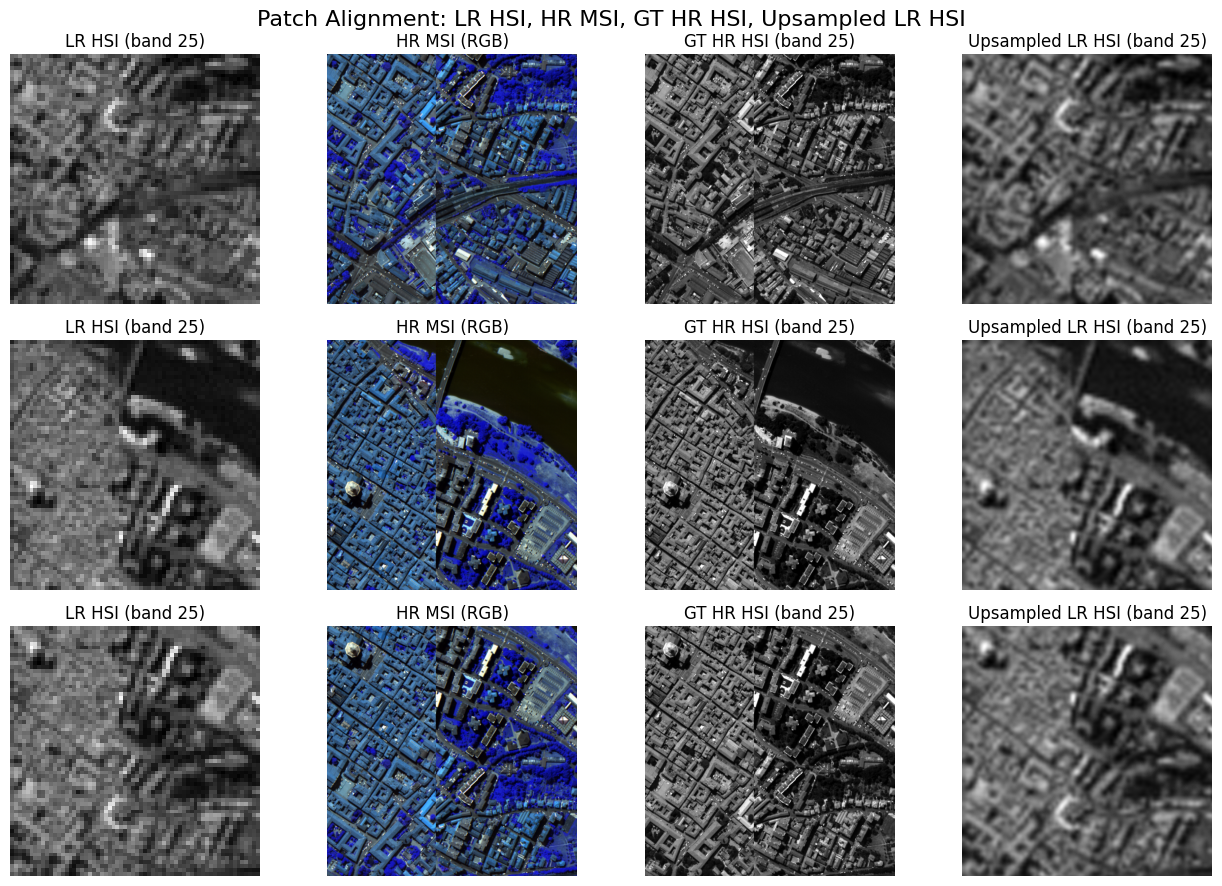

Training:   0%|          | 0/5000 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/spectralift/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Training: 100%|██████████| 5000/5000 [1:56:24<00:00,  1.40s/it, lr=0, loss=0.0127]      


Training completed in  6984.84 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3228276
FLOPs: 768127008768
GPU memory consumed: 1945.03 MB
Inference time: 0.0634 seconds
SR image shape:  (512, 512, 50)
SR image max: 1.0
SR image min: 0.0
SR image mean: 0.31549278
Saved the Super Resolved HSI 1 at location specified in uh_feinfn_folder_path


In [25]:
# Obtaining the inputs
upsampled_LR_HSI_train = upsample_hsi_to_match(I_HS_8_gaus, I_MS_3)
upsampled_LR_HSI_test_1 = upsample_hsi_to_match(LR_HSI_test_1, HR_MSI_test_1)

# Prepare patches
HR_MSI_train, LR_HSI_train, GT_train, UP_LR_HSI_train = make_patches(
    I_REF, I_MS_3, I_HS_8_gaus, upsampled_LR_HSI_train,
    patch_hr=512, scale=8, stride_hr=256
)

print(HR_MSI_train.shape)
print(LR_HSI_train.shape)
print(GT_train.shape)
print(UP_LR_HSI_train.shape)

# Build DataLoader
train_loader = torch.utils.data.DataLoader(
    PatchDS(HR_MSI_train, LR_HSI_train, GT_train, UP_LR_HSI_train),
    batch_size=4, shuffle=True, drop_last=False
)

plot_alignment_grid_np(LR_HSI_train, HR_MSI_train, GT_train, UP_LR_HSI_train, band_lr=25, band_hr=25)

LR_HSI_test_1_tensor = numpy_to_torch(LR_HSI_test_1)
HR_MSI_test_1_tensor = numpy_to_torch(HR_MSI_test_1)
upsampled_LR_HSI_test_1_tensor = numpy_to_torch(upsampled_LR_HSI_test_1)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_gaus.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_3.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_gaus.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        total_loss = 0.0

        for msi, lr, gt, up_lr in train_loader:
            msi, lr, gt, up_lr = msi.to(device), lr.to(device), gt.to(device), up_lr.to(device)

            _, loss = net.train_step(
                lr,          # (B, C_hsi, H_lr, W_lr)
                up_lr,       # (B, C_hsi, H_hr, W_hr)
                msi,         # (B, C_msi, H_hr, W_hr)
                gt,          # (B, C_hsi, H_hr, W_hr)
                criterion
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()

        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],
            "loss": f"{total_loss:.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        LR_HSI_test_1_tensor,
        upsampled_LR_HSI_test_1_tensor,
        HR_MSI_test_1_tensor,
    )
    
SR_image_1 = torch_to_numpy(SR_image_tensor)
print("SR image shape: ", SR_image_1.shape)

print("SR image max:", SR_image_1.max())
print("SR image min:", SR_image_1.min())
print("SR image mean:", SR_image_1.mean())
    
# Full file path (including the file name and extension)
file_path = f"{uh_feinfn_folder_path}/UH_topleft.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_1)

print("Saved the Super Resolved HSI 1 at location specified in uh_feinfn_folder_path")

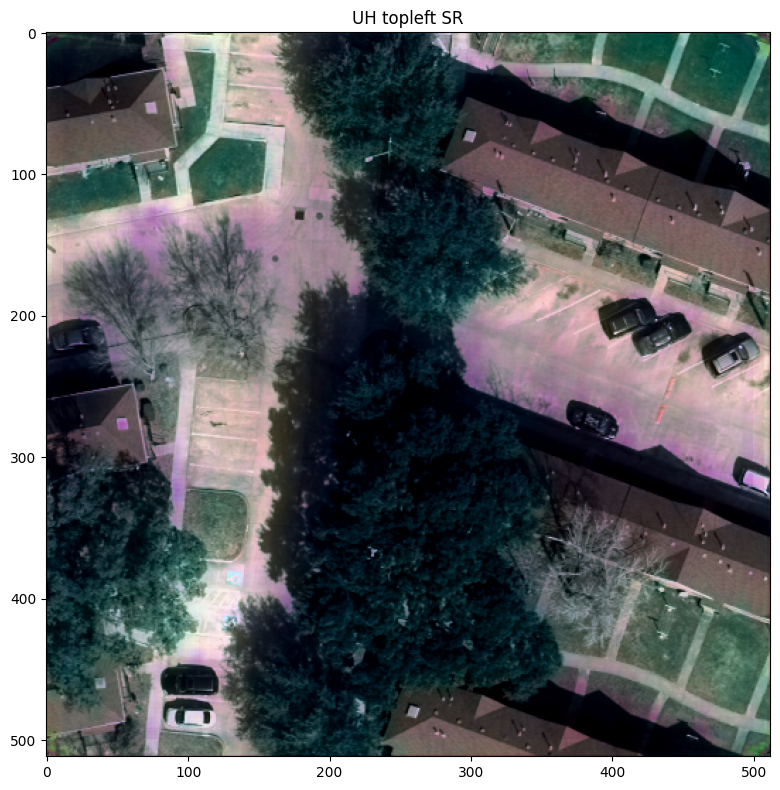

In [26]:
visualize_hsi_single(SR_image_1, (20,13,8), "UH topleft SR")

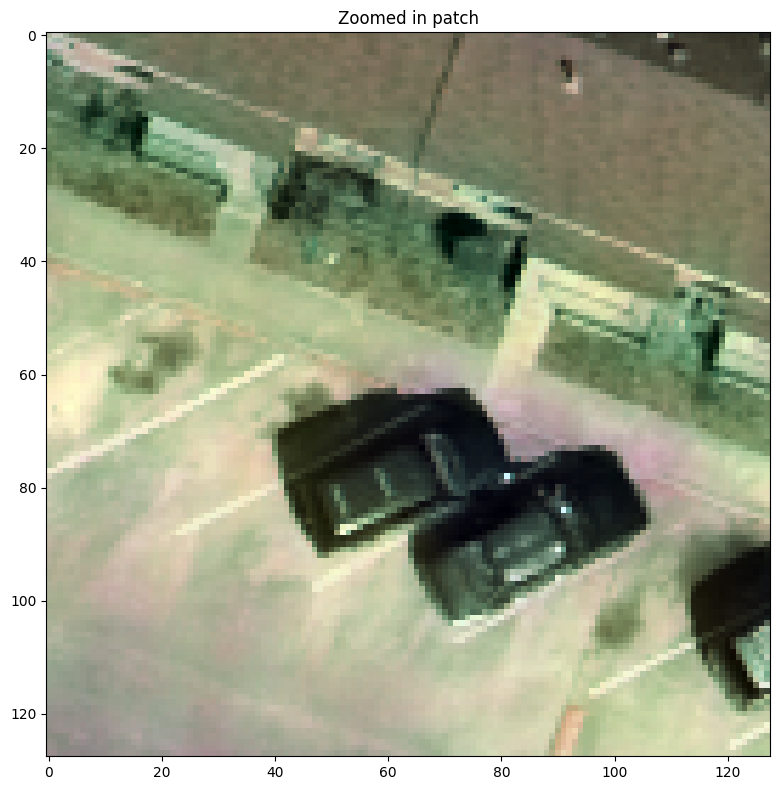

In [27]:
patch = extract_patch_at_coordinates(SR_image_1, 125, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")

Super resolving UH image 2

In [ ]:
upsampled_LR_HSI_test_2 = upsample_hsi_to_match(LR_HSI_test_2, HR_MSI_test_2)

LR_HSI_test_2_tensor = numpy_to_torch(LR_HSI_test_2)
HR_MSI_test_2_tensor = numpy_to_torch(HR_MSI_test_2)
upsampled_LR_HSI_test_2_tensor = numpy_to_torch(upsampled_LR_HSI_test_2)
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        LR_HSI_test_2_tensor,
        upsampled_LR_HSI_test_2_tensor,
        HR_MSI_test_2_tensor
    )
    
SR_image_2 = torch_to_numpy(SR_image_tensor)
print("SR image shape: ", SR_image_2.shape)

print("SR image max:", SR_image_2.max())
print("SR image min:", SR_image_2.min())
print("SR image mean:", SR_image_2.mean())
    
# Full file path (including the file name and extension)
file_path = f"{uh_feinfn_folder_path}/UH_bottomright.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image_2)

print("Saved the Super Resolved HSI 2 at location specified in uh_feinfn_folder_path")

Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3228276
FLOPs: 768127008768
GPU memory consumed: 1945.69 MB
Inference time: 0.0636 seconds
SR image shape:  (512, 512, 50)
SR image max: 1.0
SR image min: 0.0
SR image mean: 0.43675476
Saved the Super Resolved HSI 2 at location specified in uh_feinfn_folder_path


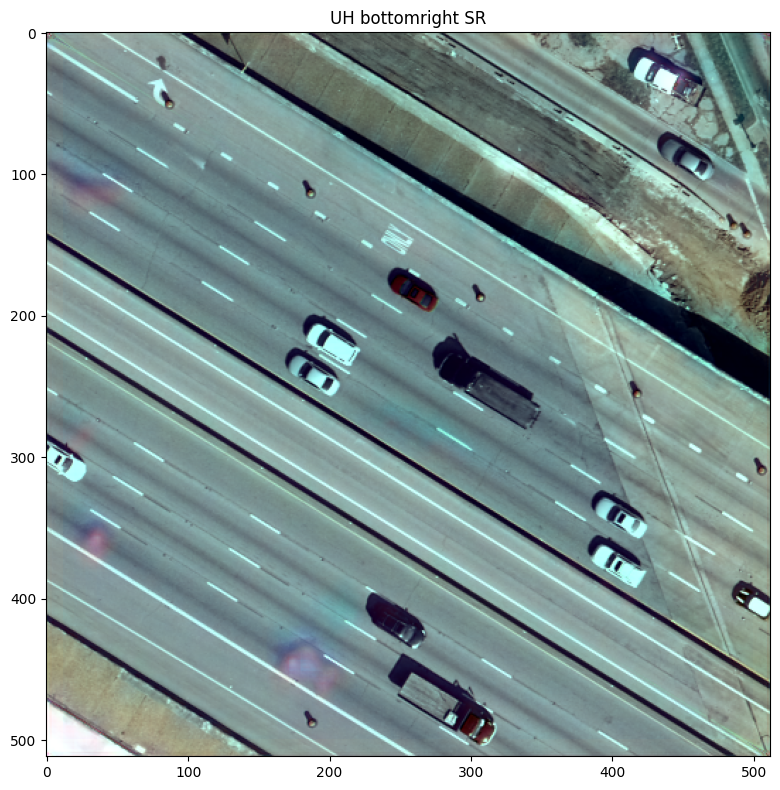

In [ ]:
visualize_hsi_single(SR_image_2, (20,13,8), "UH bottomright SR")

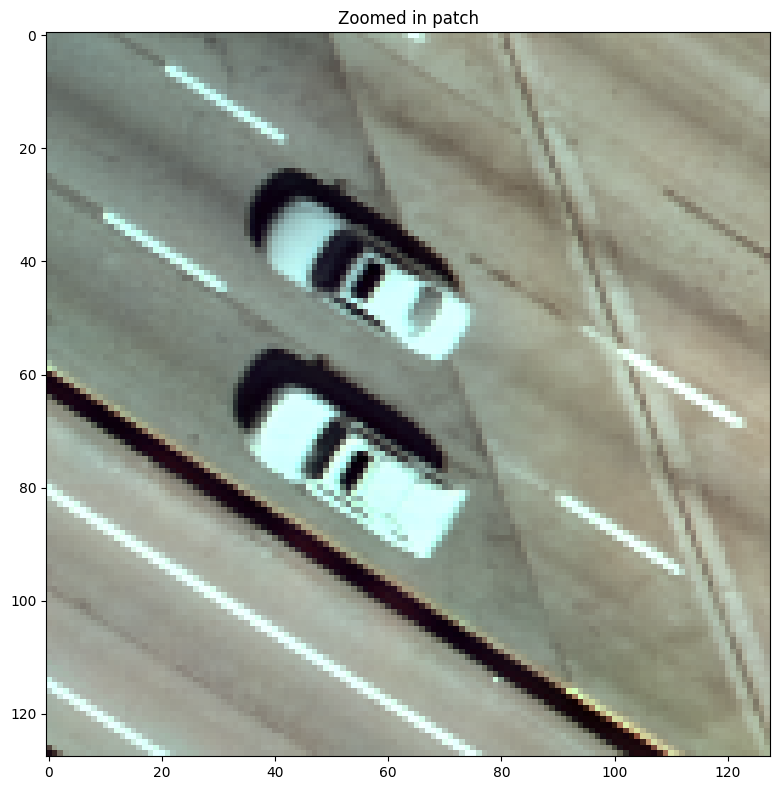

In [ ]:
patch = extract_patch_at_coordinates(SR_image_2, 300, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")